In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
import Metrics
import matplotlib.pyplot as plt

In [85]:
def encode_img_jpeg(img,x):
  img = tf.convert_to_tensor(img, dtype=tf.uint8)
  print(img)
  img = tf.io.encode_jpeg(img, format='rgb')
  img = tf.image.resize(img, [x, x])
  return img


In [4]:
(_, _), (test_images, _) = datasets.cifar10.load_data()
test_images = test_images[:10000]
# test_images = test_images.astype('float32') / 255.0
img_size = test_images.shape[1:]
print(test_images[0])

[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]]


In [5]:
SNR = 20
x = 16
k = x**2*3
n = np.prod(img_size)
k_n = k/n

decode_img = []

In [91]:
img_pil = Image.fromarray(test_images[0].astype('uint8'))

img_pil.save('j.jpeg', format='JPEG', quality=0)

In [86]:
encode_img = encode_img_jpeg(test_images[0], x)

print(encode_img.numpy())

tf.Tensor(
[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]], shape=(32, 32, 3), dtype=uint8)


ValueError: 'images' must have either 3 or 4 dimensions.

In [55]:
for test_image in test_images:
  encode_img.append(encode_img_jpeg(test_image, x))

ValueError: Tensor conversion requested dtype string for Tensor with dtype uint8: <tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[158, 112,  49],
        [159, 111,  47],
        [165, 116,  51],
        ...,
        [137,  95,  36],
        [126,  91,  36],
        [116,  85,  33]],

       [[152, 112,  51],
        [151, 110,  40],
        [159, 114,  45],
        ...,
        [136,  95,  31],
        [125,  91,  32],
        [119,  88,  34]],

       [[151, 110,  47],
        [151, 109,  33],
        [158, 111,  36],
        ...,
        [139,  98,  34],
        [130,  95,  34],
        [120,  89,  33]],

       ...,

       [[ 68, 124, 177],
        [ 42, 100, 148],
        [ 31,  88, 137],
        ...,
        [ 38,  97, 146],
        [ 13,  64, 108],
        [ 40,  85, 127]],

       [[ 61, 116, 168],
        [ 49, 102, 148],
        [ 35,  85, 132],
        ...,
        [ 26,  82, 130],
        [ 29,  82, 126],
        [ 20,  64, 107]],

       [[ 54, 107, 160],
        [ 56, 105, 149],
        [ 45,  89, 132],
        ...,
        [ 24,  77, 124],
        [ 34,  84, 129],
        [ 21,  67, 110]]], dtype=uint8)>

In [8]:
tf.print(Metrics.PSNR(train_images[0], train_images[1]))

10.0594463


In [3]:
(_, _), (test_images, _) = datasets.cifar10.load_data()
test_images = test_images[:10000]
img_size = test_images.shape[1:]

In [19]:
SNR = 20
P = 1
N = P/10**(SNR/10)
C = np.log2(1+SNR)
x = 20
k = x**2*3
n = np.prod(img_size)
k_n = k/n
R_max = k/n*C
R = R_max
# if R > 1:
#   Q = 0.5*R
# else:
#   Q=1-0.5/R
# Q = int(Q*100)
Q = R/8
Q = int(Q*100)
print(C)
print(R_max)
print(Q)
print(k_n)

4.392317422778761
1.7157489932729535
21
0.390625


In [15]:
def compress_image(image, quality):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 100]
  result, encimg = cv2.imencode('.jpeg', image, encode_param)
  if not result:
    print('could not encode image!')
    return None
  decimg = cv2.imdecode(encimg, 1)
  decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
  decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
  return decimg

In [16]:
PSNR = []
for test_image in test_images:
  decode_img = compress_image(test_image, Q)
  decode_img = decode_img/255.0
  # print(np.mean(decode_img))
  P = np.mean(decode_img)
  N = P/10**(SNR/10)
  # noise = np.random.normal(0, np.sqrt(N), decode_img.shape)
  # print(noise)
  # decode_img = decode_img + noise
  # decode_img[decode_img > 1] = 1
  # decode_img[decode_img < 0] = 0
  test_image = test_image/255.0
  PSNR.append(Metrics.PSNR(decode_img, test_image))

In [17]:
PSNR_avg = sum(PSNR)/len(PSNR)
print(PSNR_avg)

tf.Tensor(39.33548, shape=(), dtype=float32)


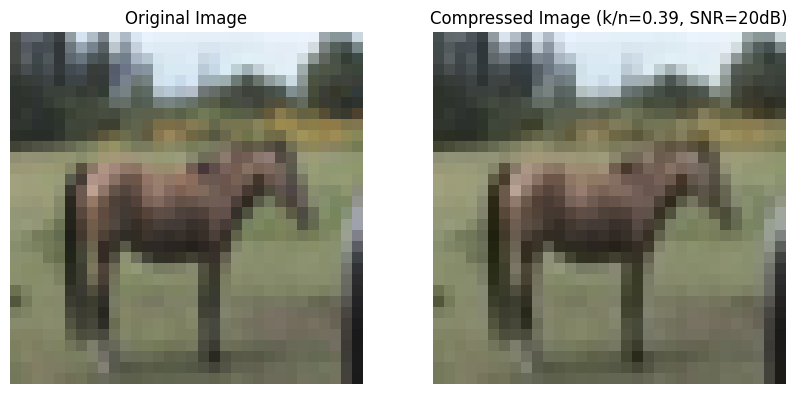

In [18]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_images[9999])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(decode_img)
axes[1].set_title(f'Compressed Image (k/n={round(k_n, 2)}, SNR={SNR}dB)')
axes[1].axis('off')

plt.show()

In [77]:
decode_img = decode_img/255.0
test_image = test_images[0]/255.0

tf.print(Metrics.PSNR(decode_img, test_images[0]))

30.5848961


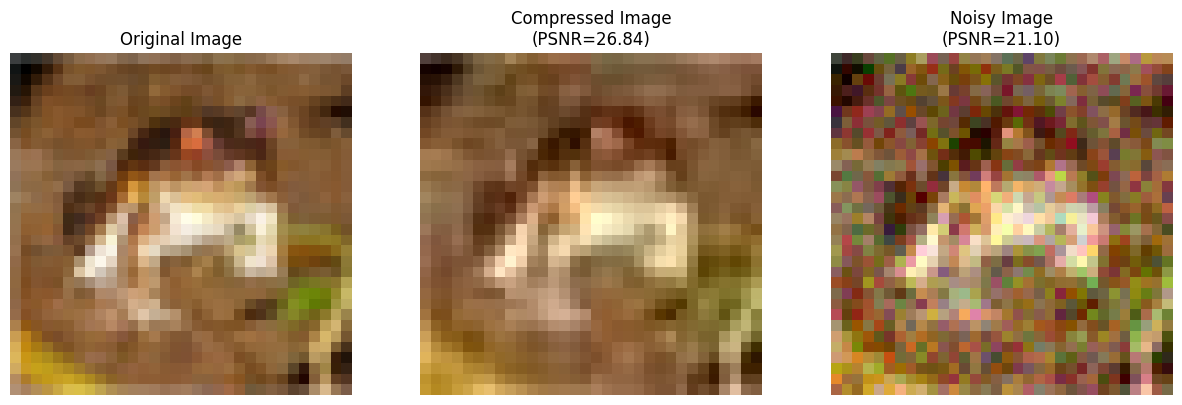

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.metrics import peak_signal_noise_ratio as psnr

# CIFAR-10データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 最初の画像を取得
original_image = x_train[0]

# JPEGで圧縮
def compress_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
    is_success, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100)) # convert to jpeg
    if not is_success:
        print('could not encode image!')
        return None
    jpeg = cv2.imdecode(jpeg, cv2.IMREAD_COLOR)
    jpeg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    return decimg

# AWGNノイズを追加
def add_awgn_noise(image, noise_std_dev):
    row, col, ch = image.shape
    mean = 0
    gauss = np.random.normal(mean, noise_std_dev, (row, col, ch))
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

# PSNRを計算
def calculate_psnr(original, compressed):
    return psnr(original, compressed, data_range=255)

# 圧縮レートを指定
quality = 50  # 圧縮レートを指定 (例: 50)
compressed_image = compress_image(original_image, quality)

# ノイズの標準偏差を指定してノイズを追加
noise_std_dev = 20
noisy_image = add_awgn_noise(compressed_image, noise_std_dev)

# PSNRの計算
psnr_compressed = calculate_psnr(original_image, compressed_image)
psnr_noisy = calculate_psnr(original_image, noisy_image)

# 結果の表示
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(compressed_image)
axes[1].set_title(f'Compressed Image\n(PSNR={psnr_compressed:.2f})')
axes[1].axis('off')

axes[2].imshow(noisy_image)
axes[2].set_title(f'Noisy Image\n(PSNR={psnr_noisy:.2f})')
axes[2].axis('off')

plt.show()


[255 216 255 ... 167 255 217]
[[[157 113  48]
  [156 112  47]
  [164 116  52]
  ...
  [137  95  35]
  [128  91  36]
  [117  84  30]]

 [[155 112  44]
  [153 108  41]
  [161 113  47]
  ...
  [136  94  34]
  [126  90  32]
  [120  88  31]]

 [[154 109  41]
  [154 107  39]
  [160 110  41]
  ...
  [138  98  36]
  [131  95  35]
  [123  88  30]]

 ...

 [[ 70 123 175]
  [ 45  98 150]
  [ 34  87 139]
  ...
  [ 42  95 145]
  [ 15  62 108]
  [ 40  85 127]]

 [[ 62 114 164]
  [ 49 101 149]
  [ 34  84 133]
  ...
  [ 29  81 129]
  [ 32  80 126]
  [ 18  65 109]]

 [[ 55 107 155]
  [ 54 104 153]
  [ 42  90 138]
  ...
  [ 25  77 124]
  [ 35  83 129]
  [ 20  67 111]]]


NameError: name 'original_image' is not defined

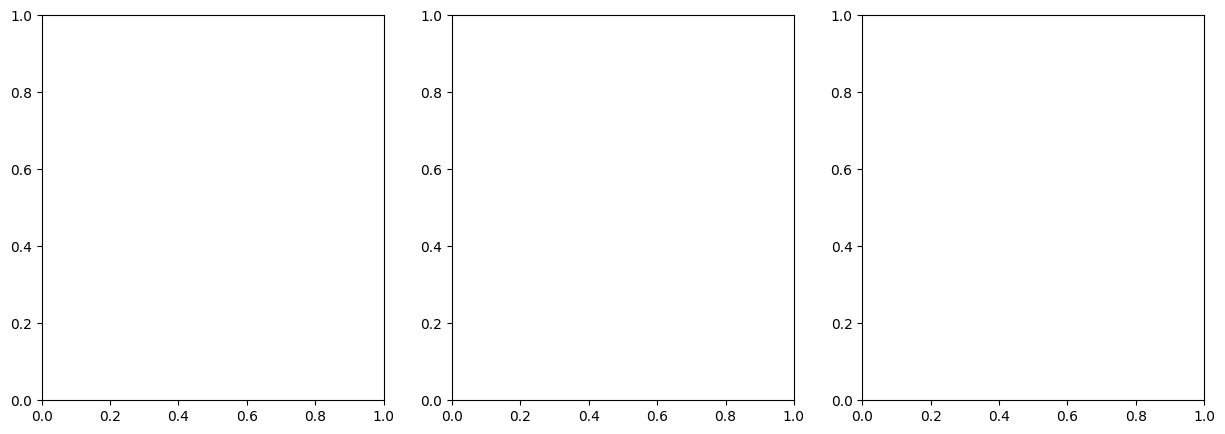

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.metrics import peak_signal_noise_ratio as psnr

# CIFAR-10データセットの読み込み
(_, _), (org_img, _) = cifar10.load_data()

# convert image to jpeg
def img2jpeg(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
    is_success, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100)) # convert to jpeg
    if not is_success:
        print('could not encode image!')
        return None
    print(jpeg)
    jpeg = cv2.imdecode(jpeg, cv2.IMREAD_COLOR) # decode
    jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
    return jpeg


# PSNRを計算
def calculate_psnr(original, compressed):
    return psnr(original, compressed, data_range=255)

jpeg = img2jpeg(org_img[0])

print(jpeg)




# PSNRの計算
# psnr_compressed = calculate_psnr(original_image, compressed_image)
# psnr_noisy = calculate_psnr(original_image, noisy_image)

# 結果の表示
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(compressed_image)
axes[1].set_title(f'Compressed Image\n(PSNR={psnr_compressed:.2f})')
axes[1].axis('off')

axes[2].imshow(noisy_image)
axes[2].set_title(f'Noisy Image\n(PSNR={psnr_noisy:.2f})')
axes[2].axis('off')

plt.show()


In [13]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# CIFAR-10データセットをロード
(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()

org_img = org_img[:100]

# トレーニングデータの画像を保存
for i in range(org_img.shape[0]):
  img = Image.fromarray(org_img[i])
  img.save(f"./images/org_img_{i}.png")

print(img)
print("画像の保存が完了しました。")


<PIL.Image.Image image mode=RGB size=32x32 at 0x19BCB068450>
画像の保存が完了しました。


TypeError: 'Image' object is not subscriptable

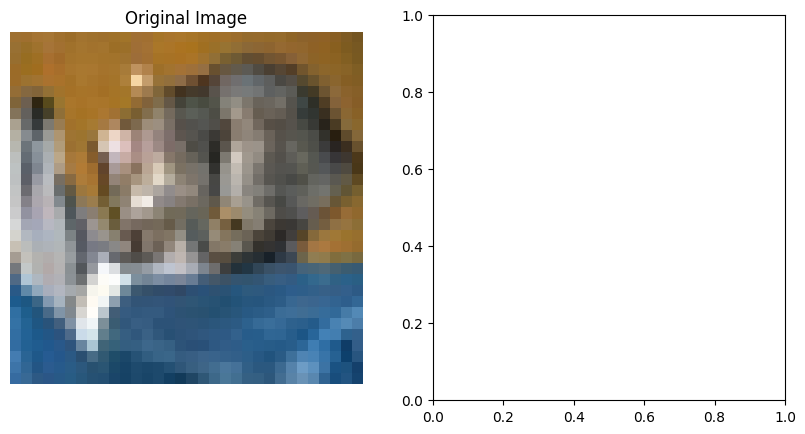

In [14]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(org_img[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img[0])
axes[1].set_title(f'JPEG')
axes[1].axis('off')

plt.show()

In [37]:
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

In [67]:
(_, _), (org_img, _) = datasets.cifar10.load_data()
opg_img = org_img[:100]

n = 32*32*3

DIR = 'images'
os.makedirs(DIR, exist_ok=True)
img = Image.fromarray(org_img[0])
img.save(f'{DIR}/org_img.bmp')
for i in range(101):
  img.save(f'{DIR}/quality_{i}.jpeg', format='JPEG', quality=i)


In [74]:
print(len(org_img[0].tobytes()))

3072


In [64]:
file_size = []
for i in range(101):
  file_size.append(os.path.getsize(f'{DIR}/quality_{i}.jpeg'))

R_max = [file_size/n*8 for file_size in file_size]

In [80]:
jpeg_img = np.array(Image.open(f'{DIR}/quality_35.jpeg'))
bmp_img = np.array(Image.open(f'{DIR}/org_img.bmp'))
print(psnr(org_img[0], jpeg_img, data_range=255))
print(psnr(org_img[0], bmp_img, data_range=255))
print(file_size[35])

25.41356706265465
inf
777


c:\Users\naoki\PythonVenv\StudyVenv\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


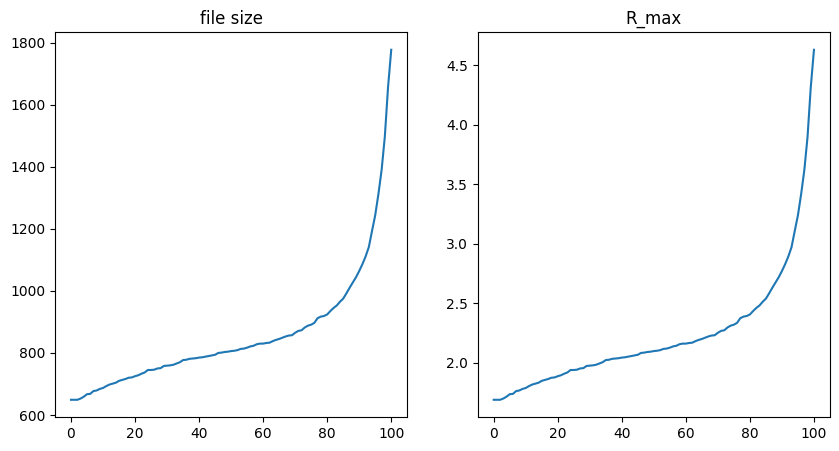

In [81]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(file_size)
axes[0].set_title('file size')

axes[1].plot(R_max)
axes[1].set_title('R_max')

plt.show()

In [71]:
import cv2
import os
import tempfile

# CIFAR-10データセットをロード
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# JPEG圧縮の品質設定（0〜100の範囲、高いほど高品質）
jpeg_quality = 20

# 一時ファイルを使用してJPEGのデータサイズを取得
def get_jpeg_size(image_array, quality):
    # OpenCVを使ってJPEG圧縮を行う
    encoded_img = cv2.imencode('.jpg', image_array, [int(cv2.IMWRITE_JPEG_QUALITY), quality])[1].tobytes()
    
    # 圧縮後のデータのバイト数を取得
    compressed_size = len(encoded_img)
    
    return compressed_size

# 最初の10個のトレーニングデータの画像を処理
for i in range(10):
    img_array = x_train[i]
    compressed_size = get_jpeg_size(img_array, jpeg_quality)
    print(f"Image {i} の圧縮後のサイズ: {compressed_size} バイト")

print("圧縮後のサイズの取得が完了しました。")


Image 0 の圧縮後のサイズ: 752 バイト
Image 1 の圧縮後のサイズ: 780 バイト
Image 2 の圧縮後のサイズ: 733 バイト
Image 3 の圧縮後のサイズ: 714 バイト
Image 4 の圧縮後のサイズ: 754 バイト
Image 5 の圧縮後のサイズ: 755 バイト
Image 6 の圧縮後のサイズ: 756 バイト
Image 7 の圧縮後のサイズ: 774 バイト
Image 8 の圧縮後のサイズ: 740 バイト
Image 9 の圧縮後のサイズ: 732 バイト
圧縮後のサイズの取得が完了しました。
